# Problem 4

In [6]:
from collections import deque
import numpy as np
from tqdm import tqdm

import networkx as nx
from matplotlib import pyplot as plt

## Design of a streaming and sampling algorithm for dynamic networks 

## First approach: brutal but easy

In order to solve the problem as it is stated, we need to reason in terms of streaming and sampling algorithm. In the given case the main question to answer how do we keep a "good statistic" of the edge flow? 

Since we are interested in connectivity, a starting point would be to be able to keep track of the edge flow in the form of the resulting *forest* arising from the sequence: considering the query design, in order to check connectivity we need to be able to check the number of connected components, and the idea of the growing forest is good in this way, since each of the tree is a connected component itself. 

In order to keep a forest of trees, we need also to be capable of querying an arriving edge $e_{t+1}$: in particular we need to know if adding it any cycle is formed. In that case, there is no improvement in connectivity, and we lose the forest-of-trees structure. 

Now we need a data structure capable of supporting the query we defined previously and also the following operations: 
+ Add a new node as a new rooted tree: if an edge comes as a pair of new nodes, we need to firstly insert them in our data structure, and then eventually link them;
+ Add a link between existing nodes: once we are sure we are correctly keeping track of new-seen nodes, we can link them accordingly to the edge stream;
+ Cut a link between existing nodes: the sliding window model requires us to be capable of splitting two trees once an edge expires accordingly to the length $w$ of the sliding window. 

A first brutal approach could be using Disjoint Forests, a data structure supporting the following operations:
+ ```make_set(x)```: insert a new node a singleton rooted-tree;
+ ```find(x)```: find the root of a node and update the path in an aggregation fashion;
+ ```union(x,y)```: link the two nodes. 

Unfortunately this data structure does not support edge cutting, but on the other hand are very easy to be implemented and the related operations are quite time-efficient. 
The workflow could be:
+ Keep a buffer for the window whose size is $\mathcal{O}(w)$;
+ Keep a buffer for the seen nodes whose size is $\mathcal{O}(V)$;
+ At each time iteration build the resulting disjoint forest adding all the seen nodes and linking them according to the active edges paying attention to the formation of cycles: this is actually very easy since an edge $(u,v)$ would form a cycle if they have the same root, so we just need to check ```find(u)``` $\neq$ ```find(v)``` before connecting them; moreover, in this brutal approach we don't need to drop the oldest edge in the cycle since we are rebuilding the entire forest at each iteration, so we just don't link two nodes if they would forma cycle.
+ Query the data structure for connectivity. 

In [21]:
class DisjointForest():
    def __init__(self):
        
        self.parents = {}
        #self.rank = {}

    def find(self,
             node):
        
        try:

            # Path aggregation 
            if self.parents[node] != node:
                self.parents[node] = self.find(self.parents[node])

            return self.parents[node]
        
        except KeyError:
            
            return None
    
    def insert(self,
               node):
        
        if not self.find(node):
            self.parents[node] = node
            #self.rank[node] = 0

    def union(self, 
              u, 
              v):
        
        root_u = self.find(u)
        root_v = self.find(v)

        if root_u == root_v:
            return False
        else:
            self.parents[root_u] = root_v
            return (u,v)
        
    def connectivity(self):
        return 'Connected' if len(set([self.find(x) for x in self.parents.keys()])) == 1 else 'Disconnected'

In [22]:
def edgeGenerator(V = 150):
    return tuple(np.random.choice(np.arange(V), size=(1,2), replace=False)[0])

def test(V, w, T):
    edge_buffer = deque(maxlen=w)
    node_buffer = set()
    
    num_cols = int(np.sqrt(T))
    num_rows = int(np.ceil(T / num_cols))
    
    _, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)  
    
    axes = axes.flatten()  
    
    for i in tqdm(range(T)):
        e = edgeGenerator(V)
        node_buffer.add(e[0])
        node_buffer.add(e[1])
        edge_buffer.appendleft(e)
        
        edge_buffer_ = []

        DF = DisjointForest()
        for v in node_buffer:
            DF.insert(v)
        for edge in edge_buffer:
            E = DF.union(edge[0], edge[1]) 
            if E:
                edge_buffer_.append(E)
            
        G = nx.Graph()
        G.add_nodes_from(node_buffer)
        G.add_edges_from(edge_buffer)
        
        pos = nx.spring_layout(G, seed=4200)
        
        ax = axes[i]
        ax.set_title(str(DF.connectivity()), fontsize=10)
        nx.draw(G, pos=pos, with_labels=True, ax=ax, node_size=30, node_color='lightblue')

    for i in range(T, num_rows * num_cols):
        axes[i].axis('off')
    
    plt.show()

100%|██████████| 64/64 [00:01<00:00, 46.75it/s]


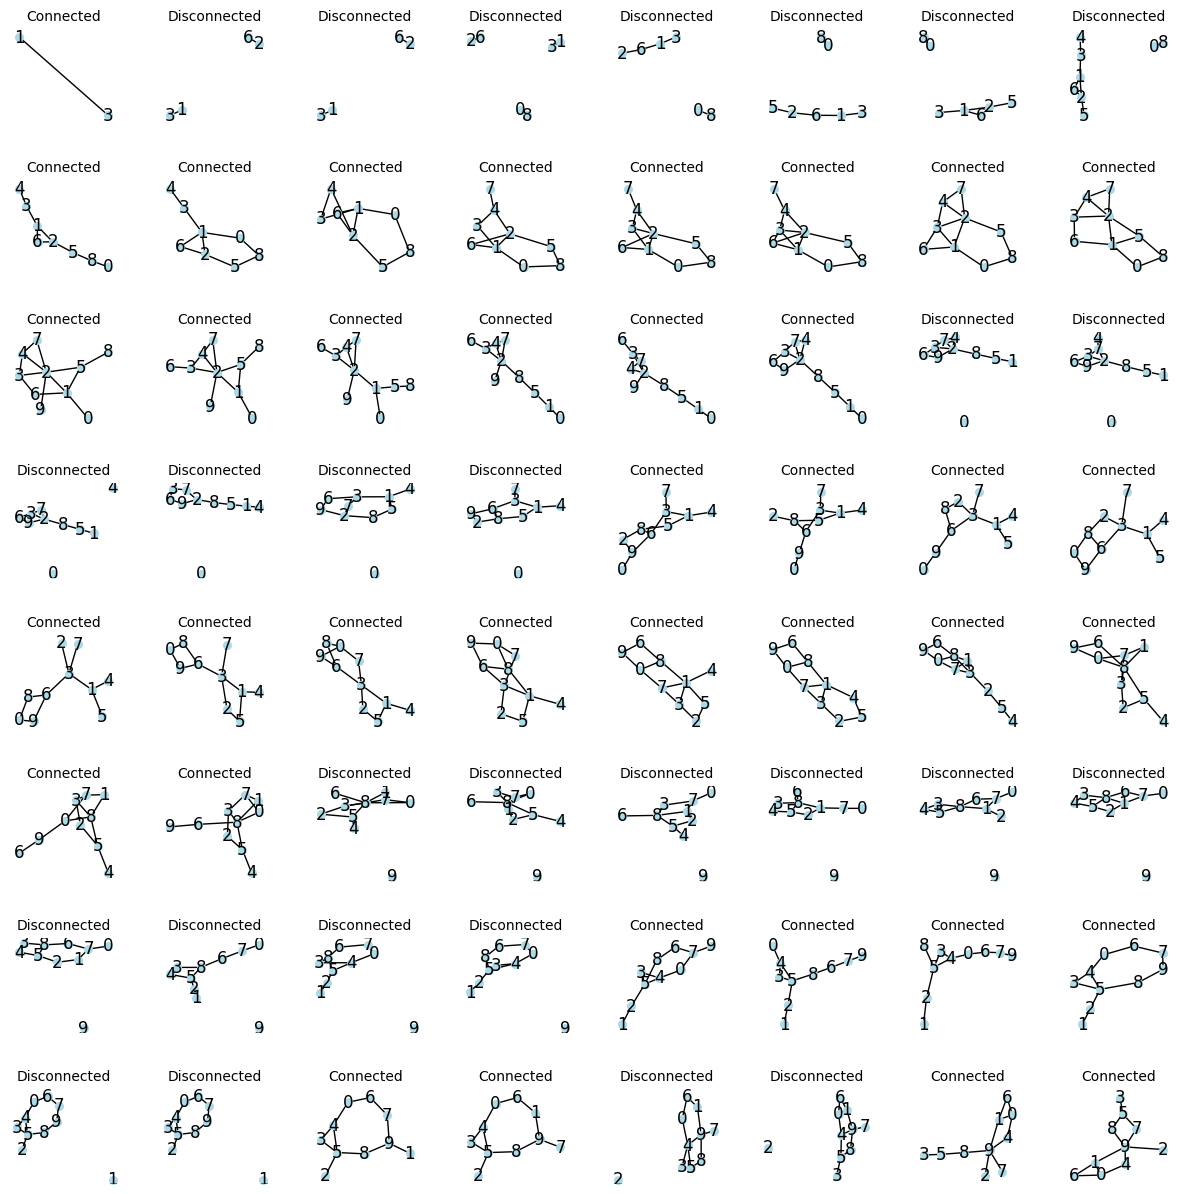

In [23]:
test(V = 10,
     w = 13,
     T = 64)

Unfortunately, this approach is not good from many perspectives of a streaming algorithm, since it doesn't leverage the state in $t$ to compute the state in $t + 1$. However:
+ It requires $\mathcal{O}(V + w)$ memory for storing the buffer of the nodes and the buffer for the edges;
+ From a time complexity perspective, at each iteration we need to: 
    + Populate the disjoint forest with $V$ elements, but each operation is constant in time $\mathcal{O}(1)$;
    + Make $E$ ```union``` operation, whose complexity is $\mathcal{O}(w \log^* V)$;
    + Compute the number of connected components, whose amortized complexity is $\Theta(\alpha(V))$.

So in the end we have:
+ $\mathcal{O}(V + w \log^*V + \alpha(V))$ for time complexity;
+ $\mathcal{O}(V + 2w)$ for space complexity.

_________